In [1]:
import sys
import random
from random import shuffle

from collections import Counter

import pandas as pd
from bs4 import BeautifulSoup
import pysrt

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

from nltk.corpus import stopwords

from tqdm.notebook import tqdm, trange

import torch
from torch import nn
device = "cuda:0" if torch.cuda.is_available() else "cpu"

import optuna

#optuna.logging.set_verbosity(optuna.logging.WARNING) 

%store -r

## Анализ таблицы

In [2]:
df = pd.read_csv('table_pazzle.csv', dtype=str, index_col=0)

In [7]:
df.dropna(inplace=True)
df.shape

(3504, 4)

In [9]:
df['level'].value_counts()

middle    1831
easy      1105
hard       568
Name: level, dtype: int64

In [12]:
df = df[df.file_name.isin(error_file) == False]
df.shape

(3461, 4)

In [13]:
df['level'].value_counts()

middle    1812
easy      1088
hard       561
Name: level, dtype: int64

In [14]:
df['level'].value_counts(normalize=True)

middle    0.523548
easy      0.314360
hard      0.162092
Name: level, dtype: float64

In [15]:
df.to_csv('final_table.csv')

## Токенезируем данные

In [8]:
df = pd.read_csv('final_table.csv', dtype=str, index_col=0)

In [9]:
def make_test(df):
    index_test = []
    for level_name in df['level'].unique():
        len_level = df[df['level'] == level_name].shape[0]
        index_test.extend(list((df['level'] == level_name).sample(int(len_level*20/100)).index))
    df_train = df.drop(index_test).copy()
    df_test = df.loc[index_test].copy()
    return df_train, df_test

In [10]:
df_train, df_test = make_test(df)

In [11]:
df_train['level'].value_counts(), df_test['level'].value_counts()

(middle    1454
 easy       903
 hard       457
 Name: level, dtype: int64,
 middle    377
 easy      200
 hard      114
 Name: level, dtype: int64)

In [12]:
# со стоп-словами
def tokens_df(srt, tokenizer, stop_words):
    tokens_list = []
    srt = [string.text for string in srt]
    for string in tokenizer.tokenizer.pipe(srt, batch_size=2000):
        tokens = tokenizer(string)
        tokens_list.extend([str(token).lower() for token in tokens \
                            if token.is_alpha])
    return tokens_list

In [13]:
stop_words = stopwords.words('english')
nlp = English()
num = 0
pbar = tqdm(df_train['file_name'], leave=False)
level = {'easy':0, 'middle':1, 'hard':2}

train_list = []
counter_words = Counter()
counter_label = Counter()
len_list = []

for index, name in enumerate(pbar):
    num+= 1
    label = level[df_train.iloc[index]['level']]
    name_film = df_train.iloc[index]['name']
    
    srt = pysrt.open(f'sub/{name}', encoding='iso-8859-1')
    tokens = tokens_df(srt, nlp, stop_words)
    
    len_list.append(len(tokens))
    counter_words.update(tokens)
    counter_label.update(str(label))
    
    train_list.append((tokens, label, name_film))

  0%|          | 0/2814 [00:00<?, ?it/s]

In [14]:
len(counter_words)

122212

In [15]:
train_list[0][1]

0

In [16]:
pbar = tqdm(df_test['file_name'], leave=False)

test_list = []

for index, name in enumerate(pbar):
    label = level[df_test.iloc[index]['level']]
    name_film = df_test.iloc[index]['name']
    
    srt = pysrt.open(f'sub/{name}', encoding='iso-8859-1')
    tokens = tokens_df(srt, nlp, stop_words)
    test_list.append((tokens, label, name_film))

  0%|          | 0/691 [00:00<?, ?it/s]

In [17]:
%store train_list
%store test_list
%store counter_words
%store counter_label
%store len_list

Stored 'train_list' (list)
Stored 'test_list' (list)
Stored 'counter_words' (Counter)
Stored 'counter_label' (Counter)
Stored 'len_list' (list)


<AxesSubplot:>

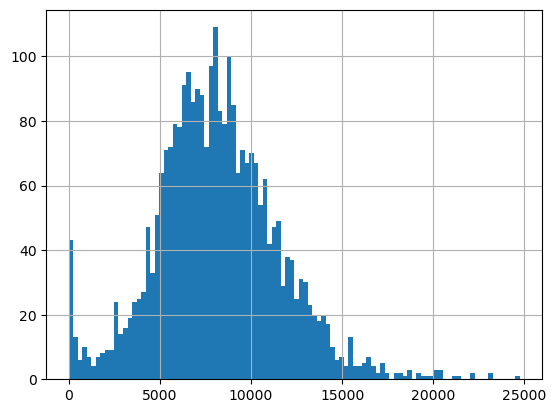

In [11]:
pd.Series(len_list).hist(bins=100)

In [12]:
pd.Series(len_list).max()

24748

In [13]:
print(pd.Series(len_list).quantile(0.5))
print(pd.Series(len_list).quantile(0.6))
print(pd.Series(len_list).quantile(0.75))

7972.0
8759.0
10157.0


In [14]:
list_words = [i[0] for i in train_list]

# Обучаем на эмбединге

## Загружаем word2vec модель

In [16]:
from gensim.models import KeyedVectors

In [17]:
wv = KeyedVectors.load("models/word2vec.model")

## Формируем батчи

In [18]:
def trans_string(list_result, index_dict, LEN_STRI):
    data = []
    for tokens, label, name in list_result:
        # прибавляем 2, так как при создании эмбеддингов это 0 pad, 1 unknow
        stri = list(map(lambda x: index_dict.get(x, -1)+2, tokens[:LEN_STRI]))
        stri = stri + [0]*(LEN_STRI - len(stri)) if len(stri) < LEN_STRI else stri
        data.append((torch.LongTensor(stri), label, name)
                   )
    return data

In [19]:
LEN_STRI = 2000
train_data = trans_string(train_list, wv.key_to_index, LEN_STRI)
test_data = trans_string(test_list, wv.key_to_index, LEN_STRI)

In [20]:
len(wv.key_to_index)

3000000

In [21]:
print(len(train_data))
train_data[0][0].shape

2811


torch.Size([2000])

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, 
                                           shuffle=True)

## Создаем модель

In [ ]:
def trans_string(list_result, index_dict, LEN_STRI):
    data = []
    for tokens, label, name in list_result:
        # прибавляем 2, так как при создании эмбеддингов это 0 pad, 1 unknow
        stri = list(map(lambda x: index_dict.get(x, -1)+2, tokens[:LEN_STRI]))
        stri = stri + [0]*(LEN_STRI - len(stri)) if len(stri) < LEN_STRI else stri
        data.append((torch.LongTensor(stri), label, name)
                   )
    return data

In [ ]:
LEN_STRI = 2000
train_data = trans_string(train_list, wv.key_to_index, LEN_STRI)
test_data = trans_string(test_list, wv.key_to_index, LEN_STRI)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, 
                                           shuffle=True)

In [23]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
                
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, 
                           n_layers, bidirectional=bidirectional,
                           dropout=dropout)
        
        hidden_dim = hidden_dim*n_layers if bidirectional == False else hidden_dim*n_layers*2
        
        self.fc = nn.Sequential(nn.Flatten(), 
                                nn.Linear(hidden_dim, int(hidden_dim/2)),
                                nn.ReLU(),
                                nn.Linear(int(hidden_dim/2), output_dim)
                               )
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2)
        
        output, (hidden, cell) = self.rnn(embedded)

        hidden = hidden.permute(1, 0, 2)
        fc = self.fc(hidden)
            
        return fc

In [24]:
embed_dim = wv['cat'].shape[0]
output_dim = len(counter_label)
n_layers = 1
bidirectional = True
dropout = 0
pad_idx = 0
model = RNNBaseline(len(wv.key_to_index)+2, embed_dim, 
                    embed_dim, output_dim, n_layers, 
                   bidirectional, dropout, pad_idx)

In [25]:
# меняем веса у эмбединга как у word2vec 
with torch.no_grad():
    for word, idx in wv.key_to_index.items():
        model.embedding.weight[idx+2] = torch.Tensor(wv.get_vector(word))

/tmp/ipykernel_27916/115841204.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  model.embedding.weight[idx+2] = torch.Tensor(wv.get_vector(word))


In [26]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad
freeze_embeddings(model, req_grad=False)

In [27]:
model.to(device)

RNNBaseline(
  (embedding): Embedding(3000002, 300, padding_idx=0)
  (rnn): LSTM(300, 300, bidirectional=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=600, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=3, bias=True)
  )
)

In [28]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, data in enumerate(train_loader):
            # print(data[0].shape)
            # print(data[1].shape)
            # input()
            
            x_gpu = data[0].to(device)
            y_gpu = data[1].to(device)
            prediction = model(x_gpu)  
            
            loss_value = loss(prediction, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]
            
            loss_accum += loss_value
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f'Average loss:{ave_loss}, train_accuracy: {round(train_accuracy, 2)},\
              val_accuracy: {round(val_accuracy, 2)}')
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):

    predict_list = []
    y_list = []
    model.eval() # Evaluation mode
    for data in loader:
        X = data[0].to(device)
        y = data[1].to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        predict_list.extend(list(index.cpu()))
        y_list.extend(list(y.cpu()))
        
    accuracy = float(sum([pred == gt for pred, gt in zip(predict_list, y_list)])) / len(predict_list)
    
    return accuracy

In [29]:
parameters = [{'params': model.rnn.parameters()},
              {'params': model.fc.parameters()}
              ]

opt = torch.optim.Adam(parameters)
loss_func = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
max_epochs = 20

In [30]:
loss_history, train_history, val_history \
= train_model(model, train_loader, val_loader, loss_func, opt, max_epochs)

Average loss:1.0357723236083984, train_accuracy: 0.52,              val_accuracy: 0.52
Average loss:0.9997428059577942, train_accuracy: 0.53,              val_accuracy: 0.51
Average loss:0.9713132977485657, train_accuracy: 0.55,              val_accuracy: 0.46
Average loss:0.9087525010108948, train_accuracy: 0.59,              val_accuracy: 0.49
Average loss:0.8320738077163696, train_accuracy: 0.64,              val_accuracy: 0.49
Average loss:0.6983506083488464, train_accuracy: 0.72,              val_accuracy: 0.48
Average loss:0.5580732226371765, train_accuracy: 0.79,              val_accuracy: 0.44
Average loss:0.41863834857940674, train_accuracy: 0.85,              val_accuracy: 0.44
Average loss:0.29247087240219116, train_accuracy: 0.9,              val_accuracy: 0.46
Average loss:0.2100418508052826, train_accuracy: 0.93,              val_accuracy: 0.45
Average loss:0.14015516638755798, train_accuracy: 0.95,              val_accuracy: 0.44
Average loss:0.1218351349234581, train_ac

# Формируем эмбединги с нуля 

In [28]:
index_word = {word:ind+2 for ind, word in enumerate(counter_words.keys())}
index_word['<PAD>'] = 0
index_word['<unknow>'] = 1

In [29]:
def trans_string(list_result, index_dict, LEN_STRI):
    data = []
    for tokens, label, name in list_result:
        # прибавляем 2, так как при создании эмбеддингов это 0 pad, 1 unknow
        stri = list(map(lambda x: index_dict.get(x, 1), tokens[:LEN_STRI]))
        stri = stri + [0]*(LEN_STRI - len(stri)) if len(stri) < LEN_STRI else stri
        data.append((torch.LongTensor(stri), label, name)
                   )
    return data

In [54]:
LEN_STRI = 150
train_data = trans_string(train_list, index_word, LEN_STRI)
test_data = trans_string(test_list, index_word, LEN_STRI)
shuffle(train_data)

In [55]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, 
                                           shuffle=True)

In [2]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
                
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, 
                           n_layers, bidirectional=bidirectional,
                           dropout=dropout)
        
        hidden_dim = hidden_dim*n_layers if bidirectional == False else hidden_dim*n_layers*2
        
        self.fc = nn.Sequential(nn.Flatten(), 
                                nn.Linear(hidden_dim, int(hidden_dim/2)),
                                nn.ReLU(),
                                nn.Linear(int(hidden_dim/2), output_dim)
                               )
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2)
        
        output, (hidden, cell) = self.rnn(embedded)

        hidden = hidden.permute(1, 0, 2)
        fc = self.fc(hidden)
            
        return fc

In [61]:
embed_dim = 100
output_dim = len(counter_label)
hidden_dim = 256
n_layers = 2
bidirectional = True
dropout = 0
pad_idx = 0
model = RNNBaseline(len(index_word), embed_dim, 
                    embed_dim, output_dim, n_layers, 
                   bidirectional, dropout, pad_idx)

In [62]:
model.to(device)

RNNBaseline(
  (embedding): Embedding(122214, 100, padding_idx=0)
  (rnn): LSTM(100, 100, num_layers=2, bidirectional=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=3, bias=True)
  )
)

In [63]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
max_epochs = 20

In [3]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, data in enumerate(train_loader):
            # print(data[0].shape)
            # print(data[1].shape)
            # input()
            
            x_gpu = data[0].to(device)
            y_gpu = data[1].to(device)
            prediction = model(x_gpu)  
            
            loss_value = loss(prediction, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]
            
            loss_accum += loss_value
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f'Average loss:{ave_loss}, train_accuracy: {round(train_accuracy, 2)},\
              val_accuracy: {round(val_accuracy, 2)}')
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):

    predict_list = []
    y_list = []
    model.eval() # Evaluation mode
    for data in loader:
        X = data[0].to(device)
        y = data[1].to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        predict_list.extend(list(index.cpu()))
        y_list.extend(list(y.cpu()))
        
    accuracy = float(sum([pred == gt for pred, gt in zip(predict_list, y_list)])) / len(predict_list)
    
    return accuracy

In [65]:
loss_history, train_history, val_history \
= train_model(model, train_loader, val_loader, loss_func, opt, max_epochs)

Average loss:1.0374284982681274, train_accuracy: 0.52,              val_accuracy: 0.55
Average loss:0.9894651174545288, train_accuracy: 0.53,              val_accuracy: 0.55
Average loss:0.8946910500526428, train_accuracy: 0.58,              val_accuracy: 0.42
Average loss:0.697466254234314, train_accuracy: 0.71,              val_accuracy: 0.43
Average loss:0.4155140817165375, train_accuracy: 0.84,              val_accuracy: 0.45
Average loss:0.22731009125709534, train_accuracy: 0.93,              val_accuracy: 0.42
Average loss:0.12437214702367783, train_accuracy: 0.97,              val_accuracy: 0.43
Average loss:0.0937967374920845, train_accuracy: 0.98,              val_accuracy: 0.44
Average loss:0.07488717883825302, train_accuracy: 0.98,              val_accuracy: 0.42
Average loss:0.05567287653684616, train_accuracy: 0.98,              val_accuracy: 0.47
Average loss:0.04208597168326378, train_accuracy: 0.98,              val_accuracy: 0.44
Average loss:0.037755709141492844, trai

# Пробуем увеличить количество данных

In [99]:
index_word = {word:ind+2 for ind, word in enumerate(counter_words.keys())}
index_word['<PAD>'] = 0
index_word['<unknow>'] = 1

In [100]:
def trans_string(list_result, index_dict, LEN_STRI):
    data = []
    for tokens, label, name in list_result:
        for index_start, index_end in zip(range(0, len(tokens), LEN_STRI), 
                                          range(LEN_STRI, len(tokens)+LEN_STRI, LEN_STRI)):
        
            stri = list(map(lambda x: index_dict.get(x, 1), tokens[index_start:index_end]))
            stri = stri + [0]*(LEN_STRI - len(stri)) if len(stri) < LEN_STRI else stri
            data.append((torch.LongTensor(stri), label, name)
                       )
    return data

In [101]:
LEN_STRI = 100
train_data_many = trans_string(train_list, index_word, LEN_STRI)
test_data_many = trans_string(test_list, index_word, LEN_STRI)
shuffle(train_data_many)

In [102]:
%store train_data_many
%store test_data_many

Stored 'train_data_many' (list)
Stored 'test_data_many' (list)


In [103]:
len(train_data)

138633

In [104]:
train_data_many[0][0].shape

torch.Size([100])

In [105]:
zero = 0 
one = 0
two = 0
qw = set()
for i in range(len(train_data_many)):
    qw.add(len(train_data_many[i][0]))
    if train_data_many[i][1] == 0:
        zero += 1
    elif train_data_many[i][1] == 1:
        one += 1
    elif train_data_many[i][1] == 2:
        two += 1
    else: 
        print('ошибка')

In [106]:
qw

{100}

In [107]:
zero, one, two

(70709, 122142, 37962)

In [108]:
train_loader = torch.utils.data.DataLoader(train_data_many, batch_size=64, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data_many, batch_size=64, 
                                           shuffle=True)

In [4]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
                
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, 
                           n_layers, bidirectional=bidirectional,
                           dropout=dropout)
        
        hidden_dim = hidden_dim*n_layers if bidirectional == False else hidden_dim*n_layers*2
        
        self.fc = nn.Sequential(nn.Flatten(), 
                                nn.Linear(hidden_dim, int(hidden_dim/2)),
                                nn.ReLU(),
                                nn.Linear(int(hidden_dim/2), output_dim)
                               )
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2)
        
        output, (hidden, cell) = self.rnn(embedded)

        hidden = hidden.permute(1, 0, 2)
        fc = self.fc(hidden)
            
        return fc

In [134]:
embed_dim = 50
output_dim = len(counter_label)
hidden_dim = 100
n_layers = 2
bidirectional = True
dropout = 0.3
pad_idx = 0
model = RNNBaseline(len(index_word), embed_dim, 
                    hidden_dim, output_dim, n_layers, 
                   bidirectional, dropout, pad_idx)

In [135]:
model.to(device)

RNNBaseline(
  (embedding): Embedding(122214, 50, padding_idx=0)
  (rnn): LSTM(50, 100, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=3, bias=True)
  )
)

In [136]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
max_epochs = 20

In [5]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, data in enumerate(train_loader):
            # print(data[0].shape)
            # print(data[1].shape)
            # input()
            
            x_gpu = data[0].to(device)
            y_gpu = data[1].to(device)
            prediction = model(x_gpu)  
            
            loss_value = loss(prediction, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]
            
            loss_accum += loss_value
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f'{epoch}. Average loss:{ave_loss}, train_accuracy: {round(train_accuracy, 2)},\
              val_accuracy: {round(val_accuracy, 2)}')
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):

    predict_list = []
    y_list = []
    model.eval() # Evaluation mode
    for data in loader:
        X = data[0].to(device)
        y = data[1].to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        predict_list.extend(list(index.cpu()))
        y_list.extend(list(y.cpu()))
        
    accuracy = float(sum([pred == gt for pred, gt in zip(predict_list, y_list)])) / len(predict_list)
    
    return accuracy

In [138]:
loss_history, train_history, val_history \
= train_model(model, train_loader, val_loader, loss_func, opt, max_epochs)

0. Average loss:0.9968255758285522, train_accuracy: 0.53,              val_accuracy: 0.56
1. Average loss:0.9865835905075073, train_accuracy: 0.53,              val_accuracy: 0.56
2. Average loss:0.9715284705162048, train_accuracy: 0.53,              val_accuracy: 0.56
3. Average loss:0.9535956382751465, train_accuracy: 0.55,              val_accuracy: 0.55
4. Average loss:0.9370211362838745, train_accuracy: 0.56,              val_accuracy: 0.56
5. Average loss:0.9214831590652466, train_accuracy: 0.57,              val_accuracy: 0.56
6. Average loss:0.9063810110092163, train_accuracy: 0.58,              val_accuracy: 0.54
7. Average loss:0.8903160095214844, train_accuracy: 0.59,              val_accuracy: 0.56
8. Average loss:0.874950110912323, train_accuracy: 0.6,              val_accuracy: 0.55
9. Average loss:0.8598862886428833, train_accuracy: 0.61,              val_accuracy: 0.55
10. Average loss:0.8444107174873352, train_accuracy: 0.62,              val_accuracy: 0.55
11. Average

Удалось уменьшить скорость переобучения, но не остановаить его. 

# Попробуем использовать optuna 

In [14]:
history = []

In [15]:
index_word = {word:ind+2 for ind, word in enumerate(counter_words.keys())}
index_word['<PAD>'] = 0
index_word['<unknow>'] = 1

In [16]:
def trans_string(list_result, index_dict, LEN_STRI):
    data = []
    for tokens, label, name in list_result:
        for index_start, index_end in zip(range(0, len(tokens), LEN_STRI), 
                                          range(LEN_STRI, len(tokens)+LEN_STRI, LEN_STRI)):
        
            stri = list(map(lambda x: index_dict.get(x, 1), tokens[index_start:index_end]))
            stri = stri + [0]*(LEN_STRI - len(stri)) if len(stri) < LEN_STRI else stri
            data.append((torch.LongTensor(stri), label, name)
                       )
    return data

In [17]:
def make_batch(train_list, test_list, index_word, LEN_STRI):
    #LEN_STRI = 100
    train_data_many = trans_string(train_list, index_word, LEN_STRI)
    test_data_many = trans_string(test_list, index_word, LEN_STRI)
    shuffle(train_data_many)
    train_loader = torch.utils.data.DataLoader(train_data_many, batch_size=64, 
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_data_many, batch_size=64, 
                                               shuffle=True)    
    
    return train_loader, val_loader

In [18]:
def make_model(vocab_size, embed_dim, hidden_dim, output_dim,
               n_layers, bidirectional, dropout):
    # vocab_size = len(index_word)
    # embed_dim = 50
    # output_dim = len(counter_label)
    # hidden_dim = 100
    # n_layers = 2
    # bidirectional = True
    # dropout = 0.3
    # pad_idx = 0
    model = RNNBaseline(vocab_size, embed_dim, 
                        embed_dim, output_dim, n_layers, 
                       bidirectional, dropout, pad_idx=0)
    model.to(device)
    return model

In [19]:
def train_and_evaluet(param):
    global train_list, test_list, index_word, counter_label
    
    train_loader, val_loader = make_batch(train_list, test_list, 
                                          index_word, param['LEN_STRI'])
    model = make_model(len(index_word), 2, param['hidden_dim'], 
                       len(counter_label), param['n_layers'], True, 
                       param['dropout'])

    opt = torch.optim.Adam(model.parameters(), lr=param['lr'])
    loss_func = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    loss_history, train_history, val_history \
    = train_model(model, train_loader, val_loader, loss_func, opt, param['epochs'])   
    
    return val_history[-1]

In [20]:
def objective(trial):
    global history 
     
    params = {
          'lr': trial.suggest_float('learning_rate', 1.5e-5, 1.5e-5),
          'epochs': trial.suggest_int("epochs", 25, 50),
          'LEN_STRI': trial.suggest_int("LEN_STRI", 50, 250), 
          #'embed_dim': trial.suggest_int("embed_dim", 10, 250), 
          'hidden_dim': trial.suggest_int("hidden_dim", 10, 250),
          'n_layers': trial.suggest_int("n_layers", 1, 3),
          'dropout': trial.suggest_float("dropout", 0, 0.4),
          }

    accuracy = train_and_evaluet(params)
    history.append((params, accuracy))

    return accuracy

In [1]:
1.5e-5

1.5e-05

In [21]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10000, show_progress_bar=True)

[I 2023-02-16 10:15:48,893] A new study created in memory with name: no-name-025d568a-012a-40c4-8cfd-7216921db53c


  0%|          | 0/10000 [00:00<?, ?it/s]

0. Average loss:1.1904152631759644, train_accuracy: 0.31,              val_accuracy: 0.27
1. Average loss:1.1616343259811401, train_accuracy: 0.31,              val_accuracy: 0.27
2. Average loss:1.1313540935516357, train_accuracy: 0.31,              val_accuracy: 0.27
3. Average loss:1.1011836528778076, train_accuracy: 0.31,              val_accuracy: 0.29
4. Average loss:1.0738098621368408, train_accuracy: 0.47,              val_accuracy: 0.56
5. Average loss:1.052178144454956, train_accuracy: 0.53,              val_accuracy: 0.56
6. Average loss:1.0361586809158325, train_accuracy: 0.53,              val_accuracy: 0.56
7. Average loss:1.0248600244522095, train_accuracy: 0.53,              val_accuracy: 0.56
8. Average loss:1.0164583921432495, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:1.010385274887085, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:1.0058926343917847, train_accuracy: 0.53,              val_accuracy: 0.56
11. Average

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.29768581997529914 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.4587370157241821, train_accuracy: 0.31,              val_accuracy: 0.27
1. Average loss:1.4259846210479736, train_accuracy: 0.31,              val_accuracy: 0.27
2. Average loss:1.4021154642105103, train_accuracy: 0.31,              val_accuracy: 0.27
3. Average loss:1.3818612098693848, train_accuracy: 0.31,              val_accuracy: 0.27
4. Average loss:1.3628004789352417, train_accuracy: 0.31,              val_accuracy: 0.27
5. Average loss:1.3443305492401123, train_accuracy: 0.31,              val_accuracy: 0.27
6. Average loss:1.3262861967086792, train_accuracy: 0.31,              val_accuracy: 0.27
7. Average loss:1.3086881637573242, train_accuracy: 0.31,              val_accuracy: 0.27
8. Average loss:1.2915120124816895, train_accuracy: 0.31,              val_accuracy: 0.27
9. Average loss:1.2747526168823242, train_accuracy: 0.31,              val_accuracy: 0.27
10. Average loss:1.258457064628601, train_accuracy: 0.31,              val_accuracy: 0.27
11. Averag

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3644146677270465 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.0586833953857422, train_accuracy: 0.31,              val_accuracy: 0.31
1. Average loss:1.0201205015182495, train_accuracy: 0.46,              val_accuracy: 0.56
2. Average loss:1.0002437829971313, train_accuracy: 0.53,              val_accuracy: 0.56
3. Average loss:0.9978833198547363, train_accuracy: 0.53,              val_accuracy: 0.56
4. Average loss:0.9974846243858337, train_accuracy: 0.53,              val_accuracy: 0.56
5. Average loss:0.9972288608551025, train_accuracy: 0.53,              val_accuracy: 0.56
6. Average loss:0.9970290064811707, train_accuracy: 0.53,              val_accuracy: 0.56
7. Average loss:0.9968826770782471, train_accuracy: 0.53,              val_accuracy: 0.56
8. Average loss:0.9967580437660217, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:0.9966767430305481, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:0.9966170191764832, train_accuracy: 0.53,              val_accuracy: 0.56
11. Avera

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.06282933196473534 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.220055341720581, train_accuracy: 0.16,              val_accuracy: 0.17
1. Average loss:1.1583545207977295, train_accuracy: 0.17,              val_accuracy: 0.29
2. Average loss:1.0989450216293335, train_accuracy: 0.5,              val_accuracy: 0.56
3. Average loss:1.0520843267440796, train_accuracy: 0.53,              val_accuracy: 0.56
4. Average loss:1.0229723453521729, train_accuracy: 0.53,              val_accuracy: 0.56
5. Average loss:1.007522702217102, train_accuracy: 0.53,              val_accuracy: 0.56
6. Average loss:1.0003730058670044, train_accuracy: 0.53,              val_accuracy: 0.56
7. Average loss:0.9976767897605896, train_accuracy: 0.53,              val_accuracy: 0.56
8. Average loss:0.9968289136886597, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:0.9966037273406982, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:0.9965417981147766, train_accuracy: 0.53,              val_accuracy: 0.56
11. Average 

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.39892437897340766 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.0039266347885132, train_accuracy: 0.53,              val_accuracy: 0.56
1. Average loss:0.9983824491500854, train_accuracy: 0.53,              val_accuracy: 0.56
2. Average loss:0.9971010684967041, train_accuracy: 0.53,              val_accuracy: 0.56
3. Average loss:0.9968110918998718, train_accuracy: 0.53,              val_accuracy: 0.56
4. Average loss:0.9967228770256042, train_accuracy: 0.53,              val_accuracy: 0.56
5. Average loss:0.9966606497764587, train_accuracy: 0.53,              val_accuracy: 0.56
6. Average loss:0.9966310262680054, train_accuracy: 0.53,              val_accuracy: 0.56
7. Average loss:0.9965683817863464, train_accuracy: 0.53,              val_accuracy: 0.56
8. Average loss:0.996563196182251, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:0.9965283870697021, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:0.9964948892593384, train_accuracy: 0.53,              val_accuracy: 0.56
11. Averag

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.27657548577588714 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.2197580337524414, train_accuracy: 0.16,              val_accuracy: 0.17
1. Average loss:1.176213026046753, train_accuracy: 0.16,              val_accuracy: 0.17
2. Average loss:1.1277614831924438, train_accuracy: 0.18,              val_accuracy: 0.29
3. Average loss:1.0791940689086914, train_accuracy: 0.47,              val_accuracy: 0.56
4. Average loss:1.0381805896759033, train_accuracy: 0.53,              val_accuracy: 0.56
5. Average loss:1.0121856927871704, train_accuracy: 0.53,              val_accuracy: 0.56
6. Average loss:1.0010768175125122, train_accuracy: 0.53,              val_accuracy: 0.56
7. Average loss:0.9982032179832458, train_accuracy: 0.53,              val_accuracy: 0.56
8. Average loss:0.9976127743721008, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:0.9974488615989685, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:0.9973477721214294, train_accuracy: 0.53,              val_accuracy: 0.56
11. Averag

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1734341001480769 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.1469342708587646, train_accuracy: 0.31,              val_accuracy: 0.27
1. Average loss:1.083331823348999, train_accuracy: 0.31,              val_accuracy: 0.27
2. Average loss:1.0323220491409302, train_accuracy: 0.39,              val_accuracy: 0.56
3. Average loss:1.0063825845718384, train_accuracy: 0.53,              val_accuracy: 0.56
4. Average loss:0.9991746544837952, train_accuracy: 0.53,              val_accuracy: 0.56
5. Average loss:0.9974188804626465, train_accuracy: 0.53,              val_accuracy: 0.56
6. Average loss:0.9973618984222412, train_accuracy: 0.53,              val_accuracy: 0.56
7. Average loss:0.9971915483474731, train_accuracy: 0.53,              val_accuracy: 0.56
8. Average loss:0.9967427253723145, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:0.9966884255409241, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:0.9969818592071533, train_accuracy: 0.53,              val_accuracy: 0.56
11. Averag

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.39590454056790075 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.1547690629959106, train_accuracy: 0.31,              val_accuracy: 0.27
1. Average loss:1.1184301376342773, train_accuracy: 0.31,              val_accuracy: 0.27
2. Average loss:1.0869741439819336, train_accuracy: 0.31,              val_accuracy: 0.27
3. Average loss:1.0629922151565552, train_accuracy: 0.31,              val_accuracy: 0.27
4. Average loss:1.0498623847961426, train_accuracy: 0.31,              val_accuracy: 0.3
5. Average loss:1.0398955345153809, train_accuracy: 0.38,              val_accuracy: 0.46
6. Average loss:1.031242847442627, train_accuracy: 0.49,              val_accuracy: 0.55
7. Average loss:1.0238126516342163, train_accuracy: 0.52,              val_accuracy: 0.56
8. Average loss:1.0176421403884888, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:1.0126253366470337, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:1.0086619853973389, train_accuracy: 0.53,              val_accuracy: 0.56
11. Average

/home/gleb/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34084287352088155 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. Average loss:1.0775705575942993, train_accuracy: 0.31,              val_accuracy: 0.27
1. Average loss:1.0269469022750854, train_accuracy: 0.42,              val_accuracy: 0.56
2. Average loss:1.0067371129989624, train_accuracy: 0.53,              val_accuracy: 0.56
3. Average loss:0.9996345639228821, train_accuracy: 0.53,              val_accuracy: 0.56
4. Average loss:0.9973170161247253, train_accuracy: 0.53,              val_accuracy: 0.56
5. Average loss:0.9966353178024292, train_accuracy: 0.53,              val_accuracy: 0.56
6. Average loss:0.9964052438735962, train_accuracy: 0.53,              val_accuracy: 0.56
7. Average loss:0.9963167905807495, train_accuracy: 0.53,              val_accuracy: 0.56
8. Average loss:0.9962854981422424, train_accuracy: 0.53,              val_accuracy: 0.56
9. Average loss:0.9962741732597351, train_accuracy: 0.53,              val_accuracy: 0.56
10. Average loss:0.996270477771759, train_accuracy: 0.53,              val_accuracy: 0.56
11. Averag

KeyboardInterrupt: 